# DO Compliance

A simple notebook to generate dissolved oxygen depletion plots as compared with the reference condition. Ecology only looks at depletions over a certain threshold when the existing value is below a certain water quality standard (which varies by location), but for my purposes of examining model behavior just looking at the DO difference is more useful. Incorporating the water quality standard into this process would not be that difficult if it's ever needed.

## Parameters

* `do_data_cdf`: The NetCDF file containing DO results. This is generated using one of the extraction notebooks or [do_rawcdf_extraction.py](do_rawcdf_extraction.py).
* `start_date`: A date string to use as day 0 when formatting plot time axes.
* `domain_out_shp`: The shapefile that defines the node areas in the analysis domain. This is generated with [ProcessGrid.ipynb](ProcessGrid).
* `ssm_full_union_shp`: The shapefile that defines the complete SSM model grid as a single polygon. This is generated with [ProcessGrid.ipynb](ProcessGrid) and is only used to depict the water boundary/geography.
* `do_threshold`: The maximum difference between existing and reference that will lead to a noncompliance event. Used for calculating noncompliant area and duration.

In [1]:
do_data_cdf = "model_results/bottom do 2008.nc"
start_date = "2008-01-01"
domain_out_shp = "gis/ssm filled domain nodes.shp"
ssm_full_union_shp = "gis/ssm full union.shp"

do_threshold = -0.2

from pathlib import Path
from os import path
from netCDF4 import Dataset
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import analysis_util as au
#%matplotlib widget
%matplotlib inline

In [2]:
do_data = Dataset(do_data_cdf)
do_data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): time(8760), node(6120)
    variables(dimensions): int32 node(node), float32 time(time), float32 existing(time, node), float32 reference(time, node)
    groups: 

Determine the timestep of the output (needed for noncompliant duration calculations later)

In [3]:
timestep = do_data['time'][2] - do_data['time'][1]
timestep

0.041666668

Calculate the DO difference between existing and reference

In [4]:
dodeltas = (do_data['existing'][:].data - do_data['reference'][:].data)
dodeltas.shape

(8760, 6120)

Determine the name to use for output files

All outputs will be in the `notebook_outs` directory. They will start with the base name (without extension) of the given NetCDF file, followed by `_docomp_`, then a descriptive name of the output.

In [5]:
out_base = Path(do_data_cdf).stem
out_file = lambda name: path.join("notebook_outs", out_base + "_docomp_" + name)

In [6]:
domain = gpd.read_file(domain_out_shp)
domain.set_index('node_id', inplace=True)
domain.head()

,depth,geometry
node_id,,
4369,45.183998,"POLYGON ((515282.150 5333310.800, 514957.767 5..."
4370,51.813999,"POLYGON ((515087.250 5334738.350, 515039.410 5..."
4371,51.813999,"POLYGON ((515720.085 5336024.300, 515678.443 5..."
4372,55.544998,"POLYGON ((516396.973 5336859.567, 516347.240 5..."
4373,60.431000,"POLYGON ((517118.153 5338021.300, 517127.570 5..."


In [7]:
au.read_base_map(ssm_full_union_shp).head()

,FID,geometry
0,0,"POLYGON ((146157.500 5556772.500, 144805.000 5..."


## Maximum DO Depletion

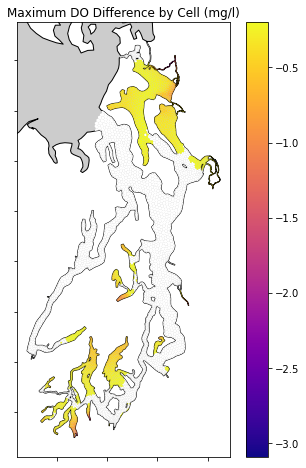

In [8]:
cmap_diff = cm.get_cmap("plasma").copy()
cmap_diff.set_over('white', 1)
diffs = dodeltas.min(axis=0)
# Normalize so differences above do_threshold are outside the bounds
norm_diff = colors.Normalize(vmin=diffs.min(), vmax=do_threshold)
data, fig = au.map_plot(domain, diffs, "Maximum DO Difference by Cell (mg/l)",
                        cmap=cmap_diff, norm=norm_diff)

data.to_file(out_file("max_difference.shp"))
data.to_excel(out_file("max_difference.xlsx"))
fig.savefig(out_file("max_difference.png"))

Find the node that experiences the largest bottom DO depletion and plot a timeseries for it comparing the existing and reference conditions

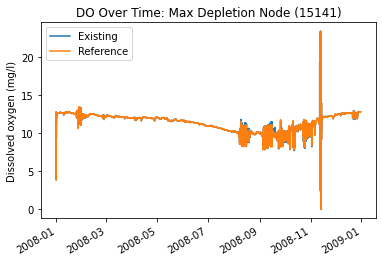

In [9]:
# The time at which the max (most negative) depletion occurs
max_depletion_time = int(dodeltas.argmin()/dodeltas.shape[1])
# The NetCDF index of the bottom cell where max depletion occurs
max_depletion_cell_idx = dodeltas[max_depletion_time,:].argmin()
# The model node number of the max bottom depletion node
max_depletion_cell = do_data['node'][max_depletion_cell_idx]
fig, ax = plt.subplots()
times = do_data['time'][:]
dates = pd.Timestamp(start_date) + pd.to_timedelta(times, 'd')
max_depletion_cell_data = pd.DataFrame({
    "existing": do_data['existing'][:,max_depletion_cell_idx],
    "reference": do_data['reference'][:,max_depletion_cell_idx],
}, index=dates)
ax.plot(max_depletion_cell_data["existing"], label="Existing")
ax.plot(max_depletion_cell_data["reference"], label="Reference")
ax.set(title="DO Over Time: Max Depletion Node ({0})".format(max_depletion_cell),
       ylabel="Dissolved oxygen (mg/l)")
ax.legend()
fig.autofmt_xdate()

fig.savefig(out_file("max_depletion_node_{0}.png".format(max_depletion_cell)))
max_depletion_cell_data.to_excel(out_file("max_depletion_node_{0}.xlsx".format(max_depletion_cell)))

## Noncompliant Area

Max noncompliant area: 489.05 km2 on 2008-09-24


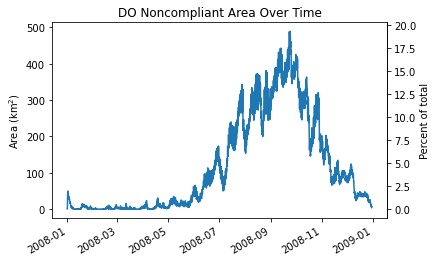

In [10]:
# Representative areas of each node in km2
areas = domain.loc[do_data['node'][:].data].area / 1e6
# Total area in km2
total_area = areas.sum()

noncompl_area = np.zeros(dodeltas.shape[0])
for t in range(dodeltas.shape[0]):
    noncompl_area[t] = areas.loc[dodeltas[t,:] < do_threshold].sum()
noncompl_area_df = pd.DataFrame({
    "Noncompliant Area (km2)": noncompl_area
}, index=dates)
print("Max noncompliant area: {0:.2f} km2 on {1}".format(
    noncompl_area_df["Noncompliant Area (km2)"].max(),
    noncompl_area_df["Noncompliant Area (km2)"].idxmax().date()
))
fig, ax = plt.subplots()
ax.plot(noncompl_area_df)
ax.set(title="DO Noncompliant Area Over Time", ylabel="Area (km$^2$)")
fig.autofmt_xdate()

def area_to_pct(a):
    return a * 100 / total_area
def pct_to_area(p):
    return p / 100 * total_area

secax = ax.secondary_yaxis('right', functions=(area_to_pct, pct_to_area))
secax.set_ylabel("Percent of total")

fig.savefig(out_file("noncompliant_area.png"))
noncompl_area_df.to_excel(out_file("noncompliant_area.xlsx"))

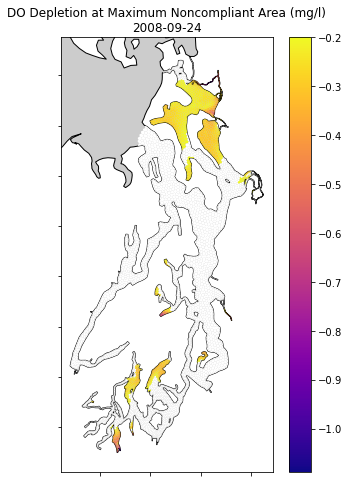

In [11]:
max_noncompl_delta = dodeltas[noncompl_area.argmax(),:]
norm_maxdiff = colors.Normalize(vmin=max_noncompl_delta.min(), vmax=do_threshold)
data, fig = au.map_plot(domain, max_noncompl_delta, 
                        "DO Depletion at Maximum Noncompliant Area (mg/l)\n{0}".format(
                            dates[noncompl_area.argmax()].date()
                        ), cmap=cmap_diff, norm=norm_maxdiff)

fig.savefig(out_file("depl_at_max_noncompliant_area.png"))
data.to_file(out_file("depl_at_max_noncompliant_area.shp"))
data.to_excel(out_file("depl_at_max_noncompliant_area.xlsx"))

## Noncompliant Duration

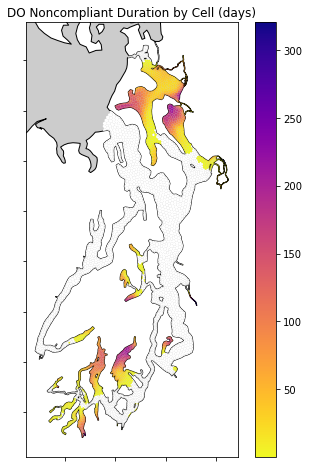

In [12]:
cmap_duration = cm.get_cmap("plasma_r").copy()
cmap_duration.set_under('white', 1)
durations = np.zeros(dodeltas.shape[1])
for i in range(dodeltas.shape[1]):
    durations[i] = np.count_nonzero(dodeltas[:,i] < do_threshold) * timestep
norm_duration = colors.Normalize(vmin=0.01, vmax=durations.max())
data, fig = au.map_plot(domain, durations, "DO Noncompliant Duration by Cell (days)",
                        cmap=cmap_duration, norm=norm_duration)

fig.savefig(out_file("noncompliant_duration.png"))
data.to_file(out_file("noncompliant_duration.shp"))
data.to_excel(out_file("noncompliant_duration.xlsx"))

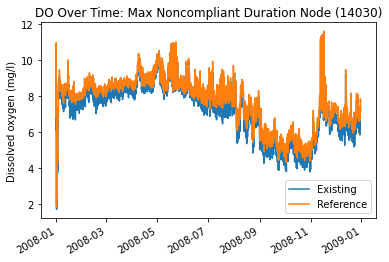

In [13]:
max_duration_cell_idx = np.argmax(durations)
max_duration_node = do_data['node'][max_duration_cell_idx]
max_duration_cell_df = pd.DataFrame({
    "existing": do_data['existing'][:,max_duration_cell_idx],
    "reference": do_data['reference'][:,max_duration_cell_idx]
}, index=dates)
fig, ax = plt.subplots()
ax.plot(max_duration_cell_df["existing"], label="Existing")
ax.plot(max_duration_cell_df["reference"], label="Reference")
ax.set(ylabel="Dissolved oxygen (mg/l)",
       title="DO Over Time: Max Noncompliant Duration Node ({0})".format(
           max_duration_node
       ))
ax.legend()
fig.autofmt_xdate()

fig.savefig(out_file("max_duration_node_{0}.png".format(max_duration_node)))
max_duration_cell_df.to_excel(out_file("max_duration_node_{0}.xlsx".format(max_duration_node)))